In [1]:
%matplotlib inline
%load_ext Cython
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from scipy import stats
from scipy.optimize import curve_fit

from lmfit.models import *
from pyarrow import csv

import warnings
warnings.filterwarnings('ignore')

from nicks_plot_utils import Hist1D, Hist2D, Scatter

MP = 0.93827208816
E0 = 4.81726
ME = 0.00051099895

COLOR_BLUE=plt.rcParams['axes.prop_cycle'].by_key()['color'][0]
COLOR_RED=plt.rcParams['axes.prop_cycle'].by_key()['color'][1]
COLOR_DGREEN=plt.rcParams['axes.prop_cycle'].by_key()['color'][3]

In [2]:
%%cython --annotate
import numpy as np
cimport numpy as np
from libc.math cimport sin, cos, sqrt
from scipy import stats
cimport cython

cdef float MP = 0.93827208816
cdef float E0 = 4.81726
#cdef float E0 = 4.8056
cdef float ME = 0.00051099895

cdef float p_targ_px = 0.0
cdef float p_targ_py = 0.0
cdef float p_targ_pz = 0.0
cdef float p_targ_E = MP

cdef float e_beam_px = 0.0
cdef float e_beam_py = 0.0
cdef float e_beam_pz = sqrt(E0**2-ME**2)
cdef float e_beam_E = E0

@np.vectorize
def calc_W(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px + p_targ_px
    cdef float temp_py = e_beam_py - e_prime_py + p_targ_py
    cdef float temp_pz = e_beam_pz - e_prime_pz + p_targ_pz
    cdef float temp_E = e_beam_E - e_prime_E + p_targ_E
    
    
    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2
    cdef float temp3 = sqrt(-temp2)
    
    
    return temp3


@np.vectorize
def calc_q2(float e_p, float e_theta, float e_phi):
    cdef float e_prime_px = e_p*sin(e_theta)*cos(e_phi)
    cdef float e_prime_py = e_p*sin(e_theta)*sin(e_phi)
    cdef float e_prime_pz = e_p*cos(e_theta)
    cdef float e_prime_E = sqrt(e_prime_px**2 + e_prime_py**2 + e_prime_pz**2 - ME**2)
    
    cdef float temp_px = e_beam_px - e_prime_px
    cdef float temp_py = e_beam_py - e_prime_py
    cdef float temp_pz = e_beam_pz - e_prime_pz
    cdef float temp_E = e_beam_E - e_prime_E

    cdef float temp2 = temp_px**2+temp_py**2+temp_pz**2-temp_E**2

    return temp2

In [3]:
@np.vectorize
def center_phi(phi, sec):
    sector = {
        1: 90,
        2: 30,
        3: -30,
        4: -90,
        5: -150,
        6: 150
    }
    
    return phi-sector[sec]

@np.vectorize
def Theta_e_calc(theta_p):
    return 2 * np.arctan(MP/((E0+MP)*np.tan(theta_p)))

@np.vectorize
def momentum_e_calc(e_theta):
    return E0/(1 + (2*E0*np.sin(e_theta/2.0)**2)/MP)

def gauss(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def FitFunc2(phi_e, theta_e,
            alpha_A, beta_A, gamma_A, 
            alpha_B, beta_B, gamma_B, 
            alpha_C, beta_C, gamma_C,
            alpha_D, beta_D, gamma_D):
    """
    Equations 5.20 - 5.22 in KPark thesis (p. 71)
    """
    A = (alpha_A * theta_e**2 + beta_A * theta_e + gamma_A) * phi_e**3
    B = (alpha_B * theta_e**2 + beta_B * theta_e + gamma_B) * phi_e**2
    C = (alpha_C * theta_e**2 + beta_C * theta_e + gamma_C) * phi_e
    D = (alpha_D * theta_e**2 + beta_D * theta_e + gamma_D)
    
    return A + B + C + D


def Dtheta(phi_e, theta_e, A, B, C, D):
    """
    Mom Corrections for e6 (CLAS-NOTE 2003-005) 
    """
    first = (A+B*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (C+D*phi_e)*np.sin(theta_e)
    return first + second

def Dpp(phi_e, theta_e, p, Bt, E, F, G, H):
    first = (E+F*phi_e)*(np.cos(theta_e)/np.cos(phi_e))
    second = (G+H*phi_e)*np.sin(theta_e)
    
    return (first + second)*(p/Bt)
    


In [4]:
#df = pd.read_csv("/Users/tylern/Data/momCorr.csv")
file_name = "/Users/tylern/Data/momCorr2.csv"

pyTable = csv.read_csv(
        file_name,
        read_options=csv.ReadOptions(use_threads=True)
    )
all_data = pyTable.to_pandas(strings_to_categorical=True)
channel = all_data[all_data.type == "channel"].copy()

df = all_data[all_data.type == "elastic"].copy()

df = df.drop(['type'], axis=1)
df = df[(df.W_uncorr > 0.5) & (df.W_uncorr < 1.5)]

df['e_phi_center'] = center_phi(np.rad2deg(df.e_phi), df.sector)
df['e_theta_calc'] = Theta_e_calc(df.p_theta)
df['delta_theta'] = df['e_theta_calc']-df['e_theta']

# df['p_p_calc'] = Theta_e_calc(df.e_theta_calc)

# df['mom_e_calc'] = momentum_e_calc(df.e_theta)
# df['delta_p'] = df.e_p/df.mom_e_calc

df = df[np.abs(df.delta_theta) < 0.005]

#df['w_corr'] = calc_W(df.e_p_corr, df.e_theta, df.e_phi)
#df['q2_corr'] = q2_calc(df.e_p_corr, df.e_theta, df.e_phi)

df.dropna(inplace=True)

In [5]:
df.head()

,e_p,e_theta,e_phi,p_p,p_theta,p_phi,W_uncorr,Q2_uncorr,sector,e_phi_center,e_theta_calc,delta_theta
17,3.377226,0.394404,2.833363,2.074239,0.685310,-0.308623,1.026782,2.528362,6,12.339742,0.393673,-0.000731
57,3.781686,0.320855,1.564746,1.696792,0.790278,-1.571506,0.957690,1.906485,1,-0.346658,0.320113,-0.000742
112,4.021086,0.270133,-1.500154,1.392392,0.875613,1.642086,0.973347,1.427006,4,4.047507,0.270290,0.000157
126,4.147535,0.249875,-2.606122,1.267144,0.917791,0.510475,0.945416,1.243310,5,0.680209,0.248127,-0.001748
155,4.073208,0.247353,2.624657,1.245117,0.928484,-0.525020,1.030437,1.214800,6,0.381769,0.242728,-0.004625


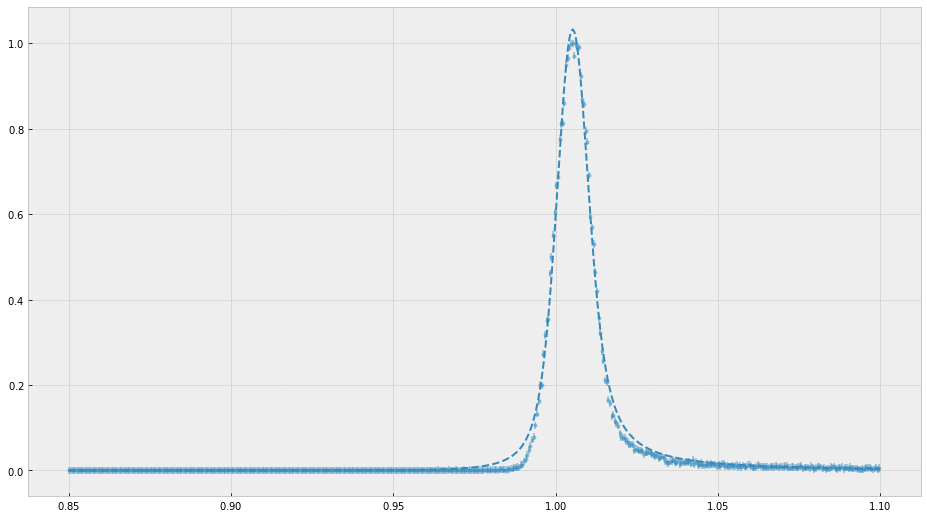

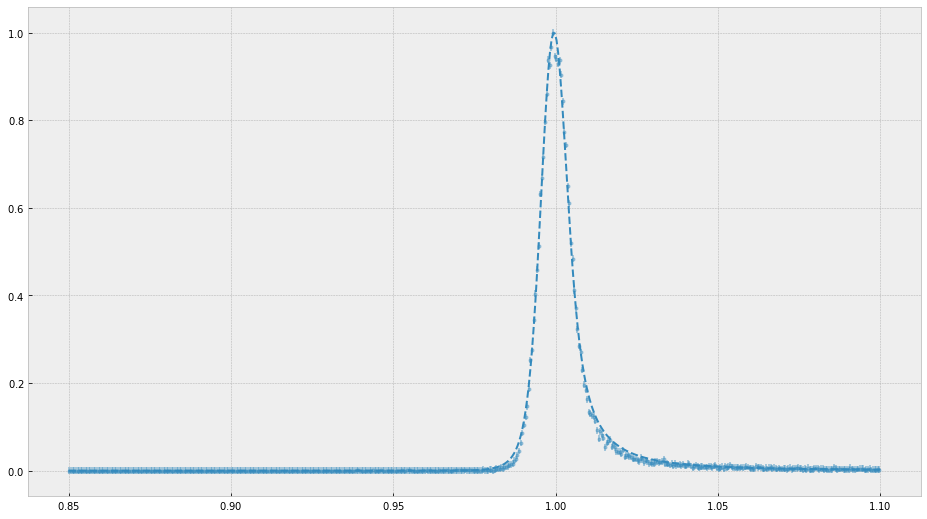

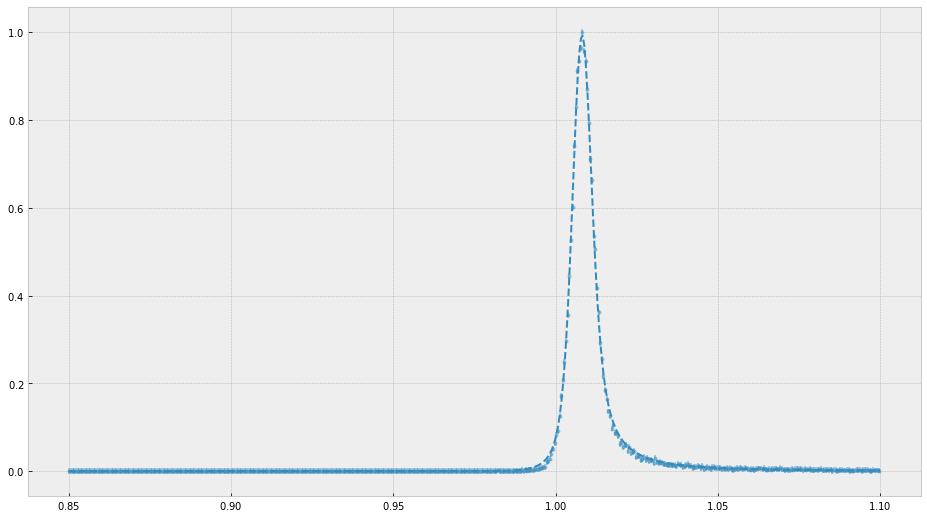

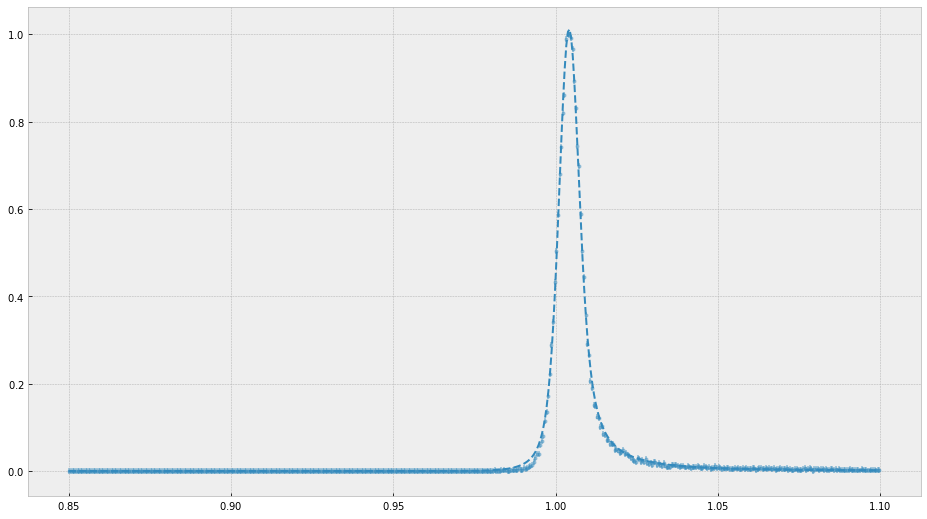

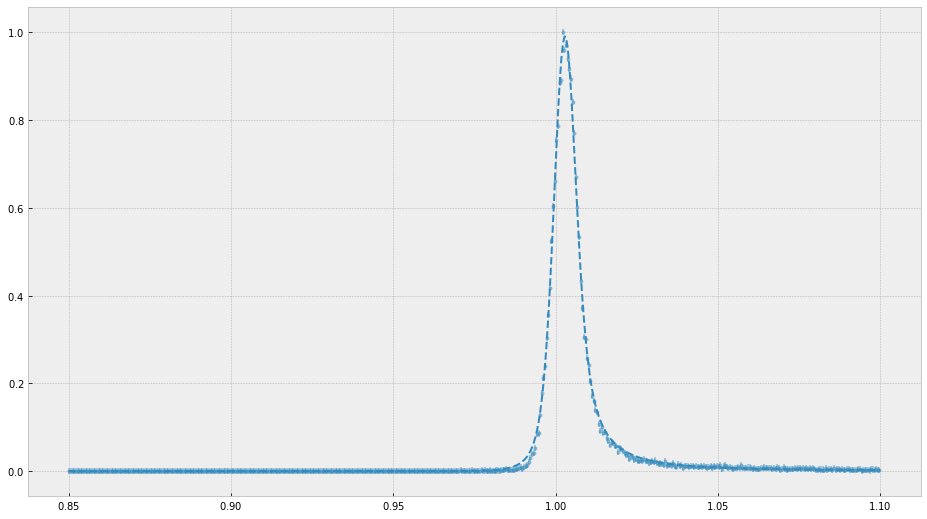

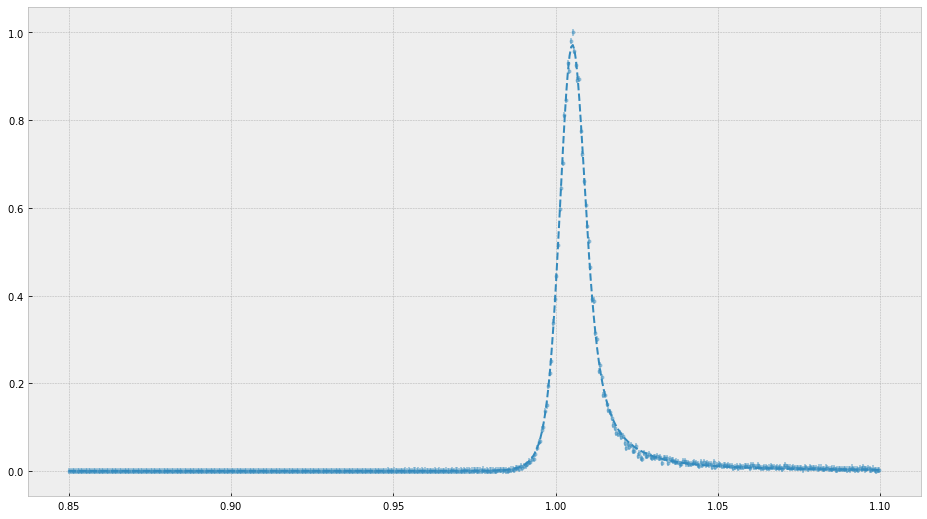

In [6]:
df['mom_e_calc'] = momentum_e_calc(df.e_theta)
df['delta_p'] = df.mom_e_calc/df.e_p


for sec in range(1,7):
    data = df[df.sector == sec].dropna()
    fig = plt.figure(figsize=(16,9))
    y, x= np.histogram(data.delta_p, bins=500, range=(0.85,1.1))
    y = y/np.max(y)
    x = (x[:-1]+x[1:])/2.0
    xs=np.linspace(0.85,1.1, 500)
    mod = SkewedVoigtModel()
    pars = mod.guess(y, x=x)
    out = mod.fit(y, pars, x=x, nan_policy='omit')        
    ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                        label=f'Sector: {sec}, {out.params["center"].value:0.2f}, \
                            {out.params["sigma"].value:0.2f}')
    plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)

In [7]:
num_points = 12
grr_p = []
for sec in range(1,7):
    for deg in range(10, 30):
        df2 = df[(df.sector == sec) & (np.rad2deg(df.e_theta) >= deg) & (np.rad2deg(df.e_theta) < deg+1)]
        phis = np.linspace(np.min(df2.e_phi_center), np.max(df2.e_phi_center), num_points+1)
        for phi in range(0, num_points):
            phi_min = phis[phi]
            phi_max = phis[phi+1]
            data = df2[(df2.e_phi_center > phi_min) & (df2.e_phi_center <= phi_max)]
            y, x = np.histogram(data['delta_p'], bins=100, range=(0.85,1.1))
            y = y/np.max(y)
            x = (x[:-1]+x[1:])/2.0

            if not np.any(np.isnan(y)) and len(y) >= 5:
                try:
                    mod = GaussianModel()
                    pars = mod.guess(y, x=x)
                    out = mod.fit(y, pars, x=x)
                    if out.params['center'] < 1.01:
                        grr_p.append([((phi_min+phi_max) / 2.0), 
                                  out.params['center'], 
                                  out.params['fwhm'], 
                                  sec, 
                                  np.deg2rad(deg)])

                except RuntimeError:
                    pass
            
grr_p = np.array(grr_p)
dfgrr_p = pd.DataFrame(data=grr_p, columns=["phi", "dP", "sigma", "sec", "min_deg"])

1


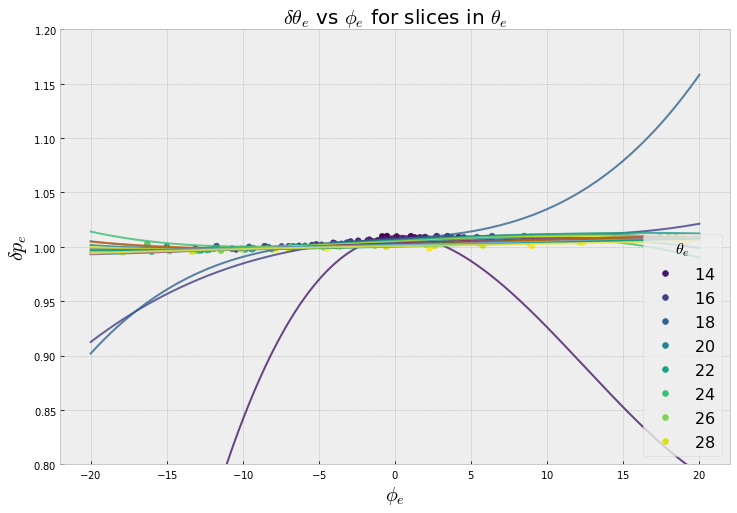

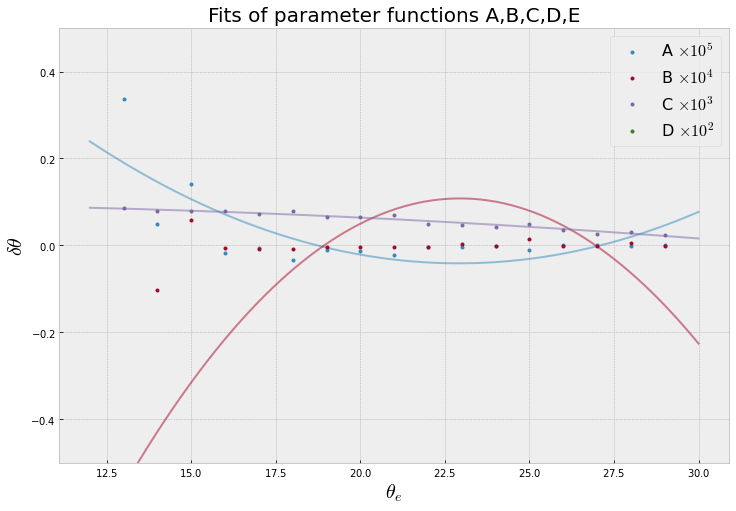

2


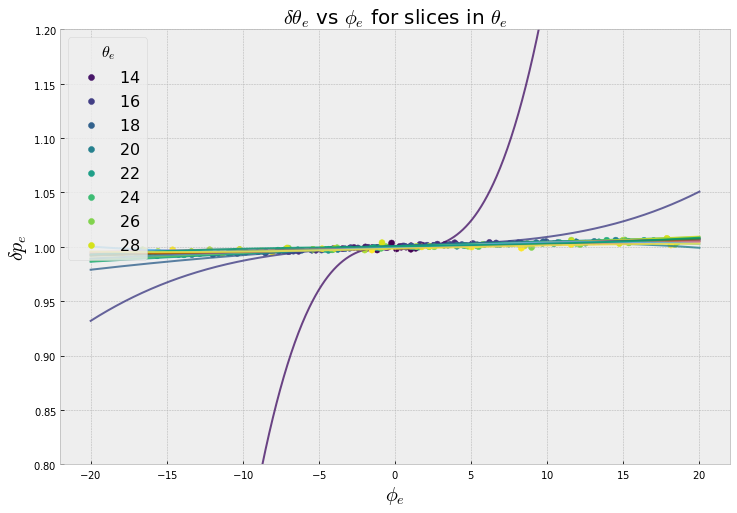

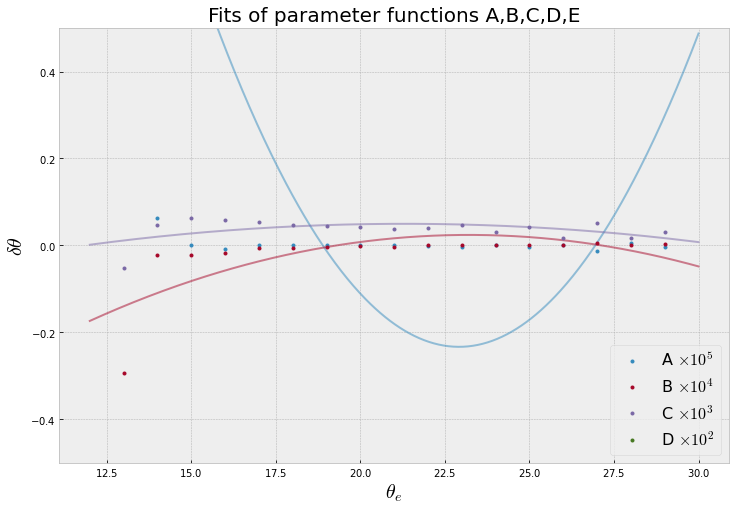

3


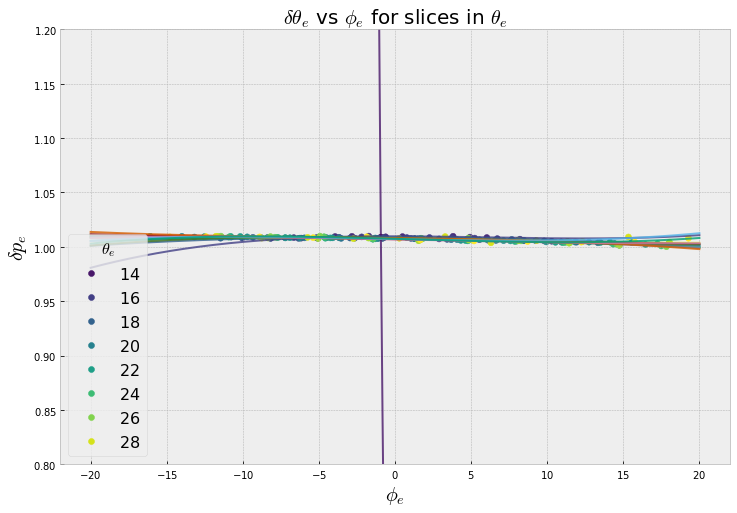

No handles with labels found to put in legend.


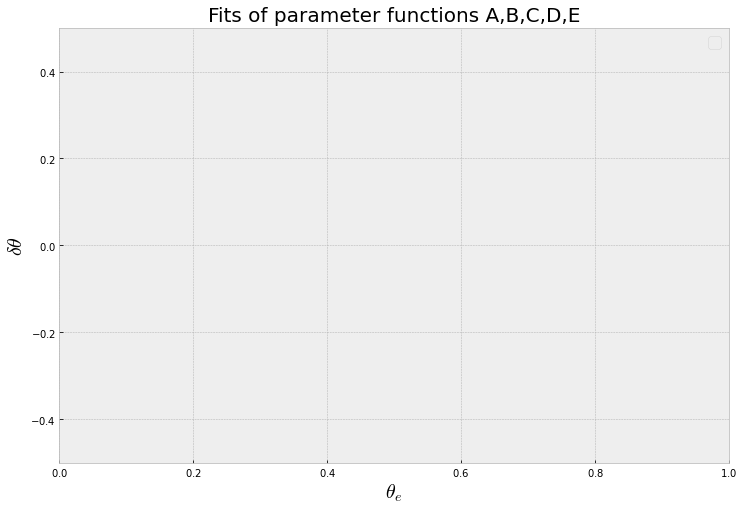

4


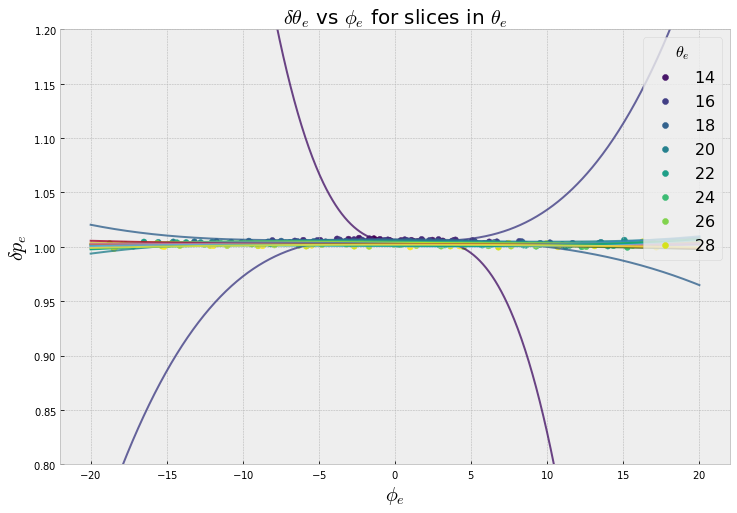

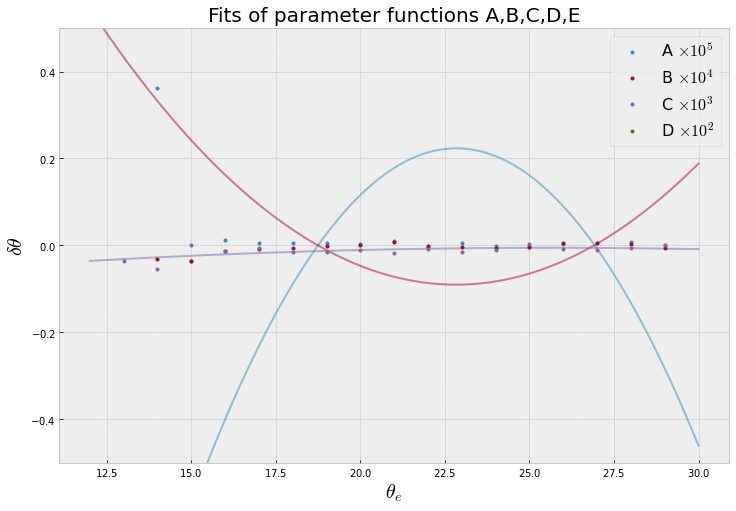

5


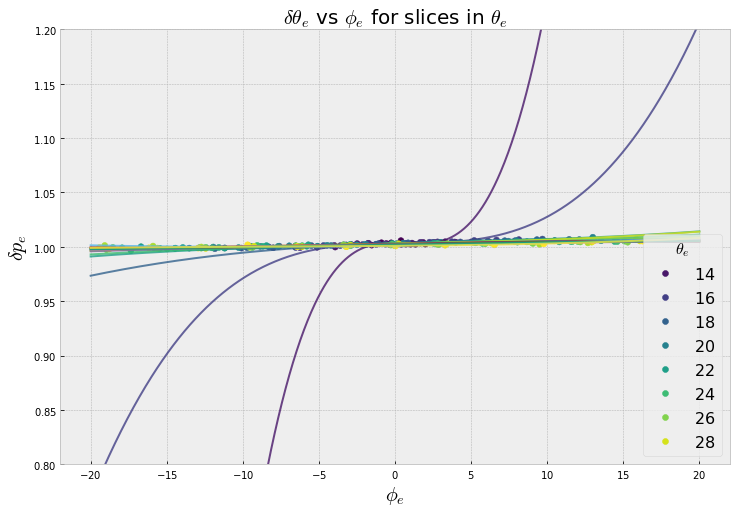

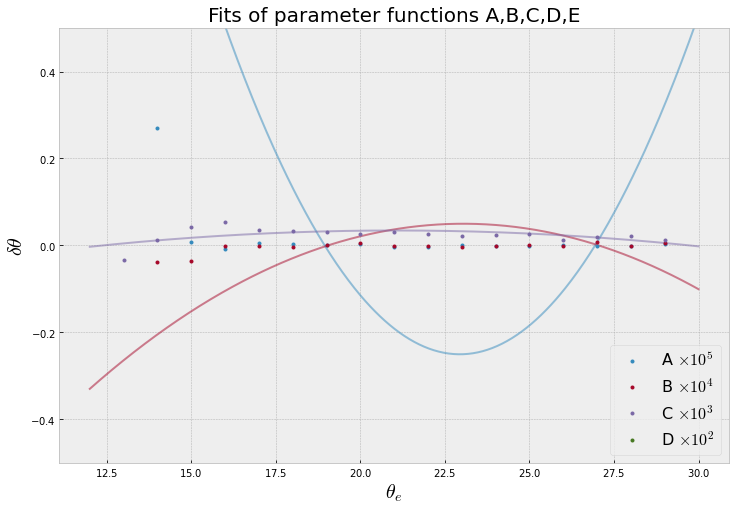

6


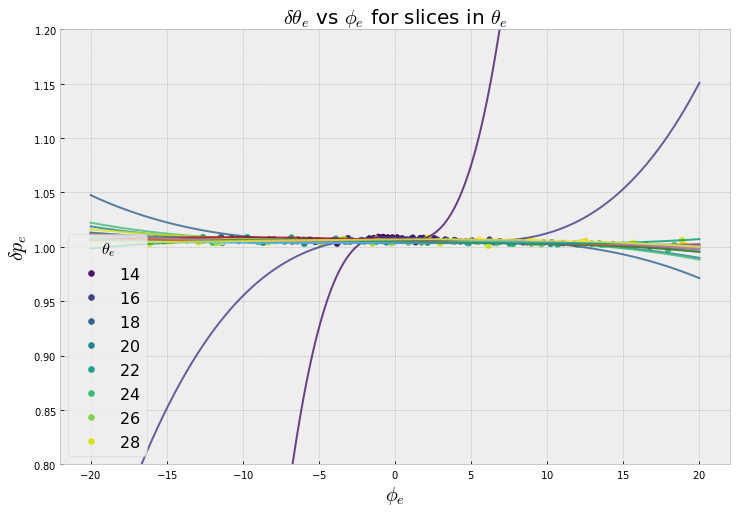

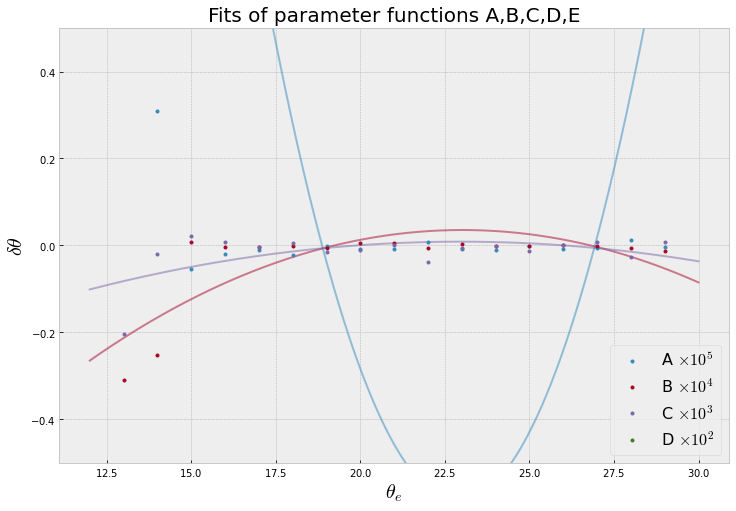

{'sec_1_A_alpha': 2.3543476765623437e-07, 'sec_1_A_beta': -1.0789459805987701e-05, 'sec_1_A_gamma': 0.00011950388983544441, 'sec_1_B_alpha': -6.70296328019533e-06, 'sec_1_B_beta': 0.00030759114392396304, 'sec_1_B_gamma': -0.0034206069324284488, 'sec_1_C_alpha': -1.0965465061148942e-06, 'sec_1_C_beta': 6.8348992727907225e-06, 'sec_1_C_gamma': 0.0009428349002572971, 'sec_1_D_alpha': 1.9232842812285916e-05, 'sec_1_D_beta': -0.0013395079817838823, 'sec_1_D_gamma': 1.0231337102300857, 'sec_2_A_alpha': 1.4366462671755753e-06, 'sec_2_A_beta': -6.585136296553494e-05, 'sec_2_A_gamma': 0.0007312958730709822, 'sec_2_B_alpha': -1.5728425825496542e-06, 'sec_2_B_beta': 7.302319537072055e-05, 'sec_2_B_gamma': -0.0008233390688640697, 'sec_2_C_alpha': -5.5638177177558556e-06, 'sec_2_C_beta': 0.00023705371843642272, 'sec_2_C_gamma': -0.0020271589470840035, 'sec_2_D_alpha': 2.878053283066876e-06, 'sec_2_D_beta': -0.00019329706338794693, 'sec_2_D_gamma': 1.0024398949012037, 'sec_4_A_alpha': -1.33337843206

In [56]:
final_fit_parameters_P = {}
for sec in range(1,7):
#for sec in [2,4]:
    print(sec)
    xs = np.linspace(-20,20,1000)
    d = dfgrr_p[dfgrr_p.sec == sec]
    fig = plt.figure(figsize=(12,8))
    scatter = plt.scatter(d.phi, d.dP, c=np.rad2deg(d.min_deg))
    sec_values = []
    for i, deg in enumerate(np.unique(d.min_deg)):
        d2 = dfgrr_p[(dfgrr_p.sec == sec) & (dfgrr_p.min_deg == deg)]
        z = np.polyfit(d2.phi, d2.dP, 3)
        p = np.poly1d(z)
        sec_values.append(z)
        
        #mod = PolynomialModel(3)
        #pars = mod.guess(d2.dP, x=d2.phi)
        #out = mod.fit(d2.dP, pars, x=d2.phi) 
        try:
            plt.plot(xs, p(xs), alpha=0.8, c=scatter.legend_elements()[0][i].get_color())
        except IndexError:
            plt.plot(xs, p(xs), alpha=0.8)
        plt.xlabel("$\phi_e$")
        plt.ylabel("$\delta p_e$")
        # print(out.params)
        
    legend = plt.legend(*scatter.legend_elements(), title="$\\theta_e$")
    plt.ylim(0.8, 1.2)
    plt.title("$\delta \\theta_e$ vs $\phi_e$ for slices in $\\theta_e$")
    plt.show()
    
    fig = plt.figure(figsize=(12,8))
    sec_values = np.array(sec_values)

    label="ABCD"
    for i, letter in enumerate(label):
        scalling = 10**(4-i)
        x = np.unique(np.rad2deg(dfgrr_p.min_deg))
        y = sec_values.T[i]
        
        if len(x) != len(y):
            continue
        sca = plt.errorbar(x, y*scalling, fmt='.', label=f'{letter} $\\times 10^{(5-i)}$')
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        xx = np.linspace(12, 30, 500)
        plt.plot(xx, p(xx)*scalling, alpha=0.5, c=sca[0].get_color())
        
        mod = PolynomialModel(2)
        pars = mod.guess(y, x=x)
        
        #pars['c0'].set(value=0, min=-1E-4, max=1E-4)
        #pars['c1'].set(value=0, min=-1E-4, max=1E-4)
        #pars['c2'].set(value=0, min=-1E-15)
        

        out = mod.fit(y, pars, x=x) 
        #plt.plot(xx, out.eval(params=out.params, x=xx), alpha=0.8, c=sca[0].get_color())


        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters_P[f'sec_{sec}_{letter}_{abc}'] = z[j]
            #final_fit_parameters[f'sec_{sec}_{letter}_{abc}'] = out.params[f'c{j}'].value
    
    plt.ylim(-0.5, 0.5)
    plt.title("Fits of parameter functions A,B,C,D,E")
    plt.ylabel("$\delta \\theta$")
    plt.xlabel("$\\theta_e$")
    plt.legend()
    plt.show()
    
print(final_fit_parameters_P)

1
[[0.22689280275926285
  array([ 4.49527742e-04,  1.40670821e-04, -2.65903562e-03,  6.91663947e-04,
          1.01057374e+00])                                                  ]
 [0.24434609527920614
  array([-1.29782871e-05,  1.23881987e-05,  1.05329991e-04,  7.21257785e-04,
          1.00715153e+00])                                                  ]
 [0.2617993877991494
  array([2.19085151e-06, 2.97056506e-05, 5.35657938e-05, 6.77210377e-04,
         1.00699477e+00])                                               ]
 [0.2792526803190927
  array([ 1.11911834e-06,  9.08145280e-06, -9.04974703e-06,  6.39356973e-04,
          1.00592181e+00])                                                  ]
 [0.29670597283903605
  array([-3.73585802e-07, -3.63177767e-06,  9.83572525e-06,  8.13723201e-04,
          1.00568358e+00])                                                  ]
 [0.3141592653589793
  array([ 3.02432355e-07,  3.82625789e-07, -1.28520719e-05,  6.76218360e-04,
          1.00537177e+00]

ValueError: 'x' and 'y' must have the same size

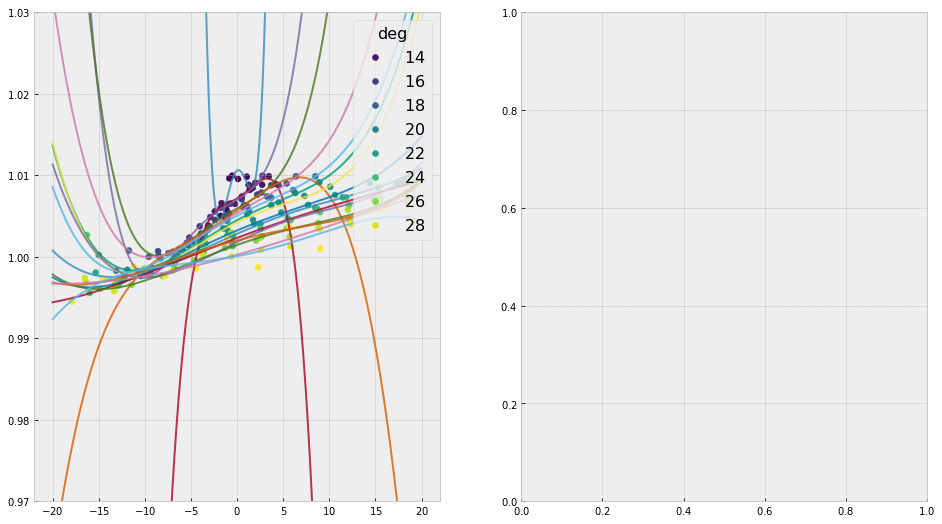

In [30]:
final_fit_parameters_P = {}
for sec in range(1,7):
    for i, letter in enumerate("ABCD"):
        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters_P[f'sec_{sec}_{letter}_{abc}'] = 1
        
        
for sec in range(1,7):
    print(sec)
    xs = np.linspace(-20,20,1000)
    mu = np.mean(dfgrr_p.dP)
    sig = np.std(dfgrr_p.dP)
    nsig = 3
    
    d = dfgrr_p[(dfgrr_p.sec == sec) & (np.abs(dfgrr_p.dP) < mu+nsig*sig)]
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
    scatter = ax[0].scatter(d.phi, d.dP, c=np.rad2deg(d.min_deg))
    sec_values = []
    for deg in np.unique(dfgrr_p.min_deg):
        d2 = dfgrr_p[(dfgrr_p.sec == sec) & (dfgrr_p.min_deg == deg)]
        if len(d2) < 4:
            continue
        z = np.polyfit(d2.phi, d2.dP, 4)
        p = np.poly1d(z)
        ax[0].plot(xs, p(xs), label=z, alpha=0.8)
        sec_values.append([deg, z])

    legend = ax[0].legend(*scatter.legend_elements(), title="deg", loc='upper right')
    ax[0].set_ylim(0.97, 1.03)
    
    

    sec_values = np.array(sec_values)
    print(sec_values)
    label="ABCD"
    for i, letter in enumerate("ABCD"):
        ys = sec_values.T[i]
        min_deg = sec_values.T[0][i] #np.unique(dfgrr_p.min_deg)


            
        print(min_deg, ys)
        #min_deg = min_deg[ np.abs(ys*10**(4-i)) < 0.2 ]
        #ys = ys[ np.abs(ys*10**(4-i)) < 0.2 ]
        
        


        sca = ax[1].errorbar(min_deg, ys*10**(4-i), fmt='.', label=letter)
        
        z = np.polyfit(min_deg, ys, 2)
        p = np.poly1d(z)
        xx = np.linspace(0.2, 0.5, 500)
        ax[1].plot(xx, p(xx)*10**(4-i), alpha=0.5, c=sca[0].get_color())
        
        mod = PolynomialModel(2)
        pars = mod.guess(y, x=x)
        
        pars['c0'].set(value=0, min=-1E-4, max=1E-4)
        pars['c1'].set(value=0, min=-1E-4, max=1E-4)
        pars['c2'].set(value=0, min=0)

        out = mod.fit(y, pars, x=x) 
        #plt.plot(xx, out.eval(params=out.params, x=xx)*10**(5-i), alpha=0.8, c=sca[0].get_color())


        for j, abc in enumerate(['alpha','beta','gamma']):
            final_fit_parameters_P[f'sec_{sec}_{letter}_{abc}'] = z[j]
            # final_fit_parameters_P[f'sec_{sec}_{letter}_{abc}'] = out.params[f'c{j}'].value
    
    ax[1].set_ylim(-0.5, 0.5)
    ax[1].legend(loc='upper right')
    plt.show()
    
print(final_fit_parameters_P)


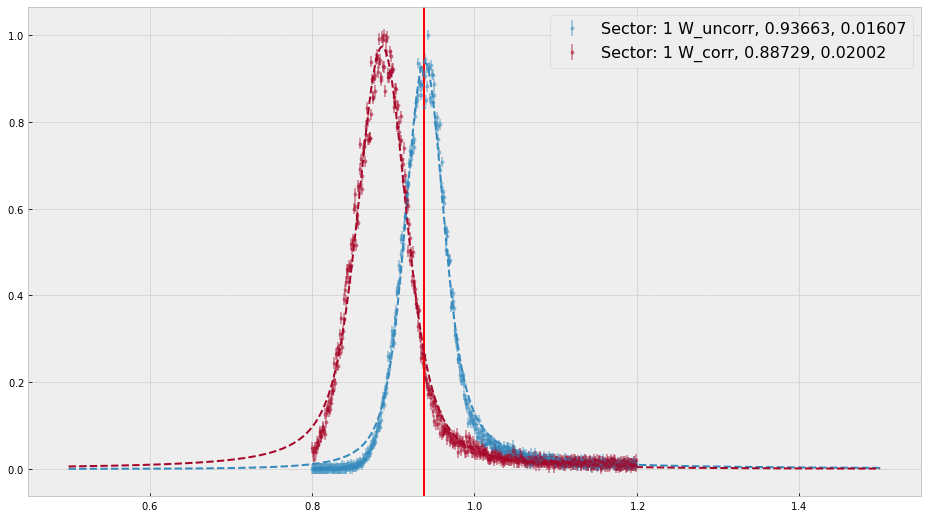

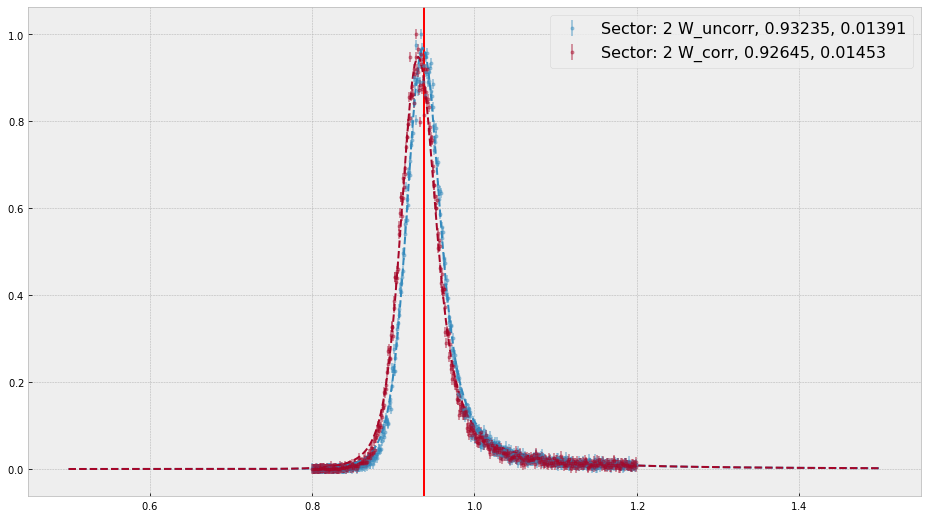

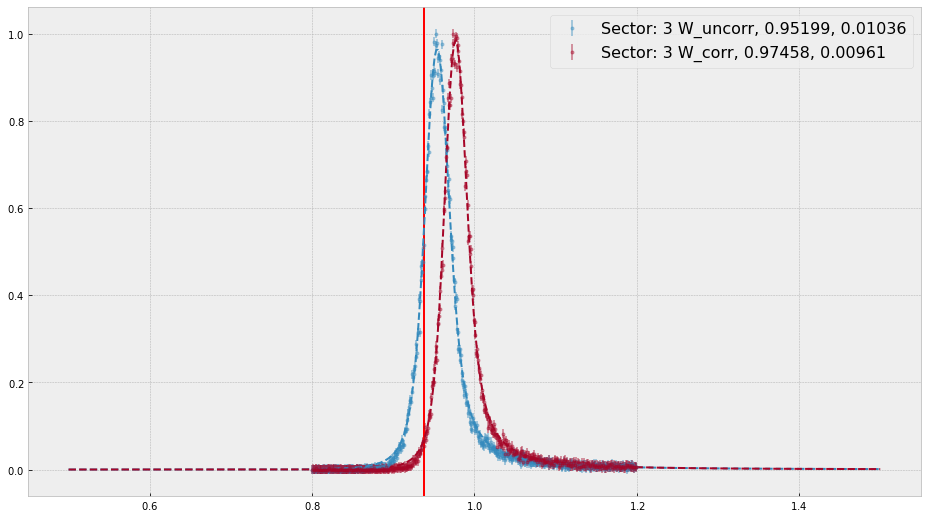

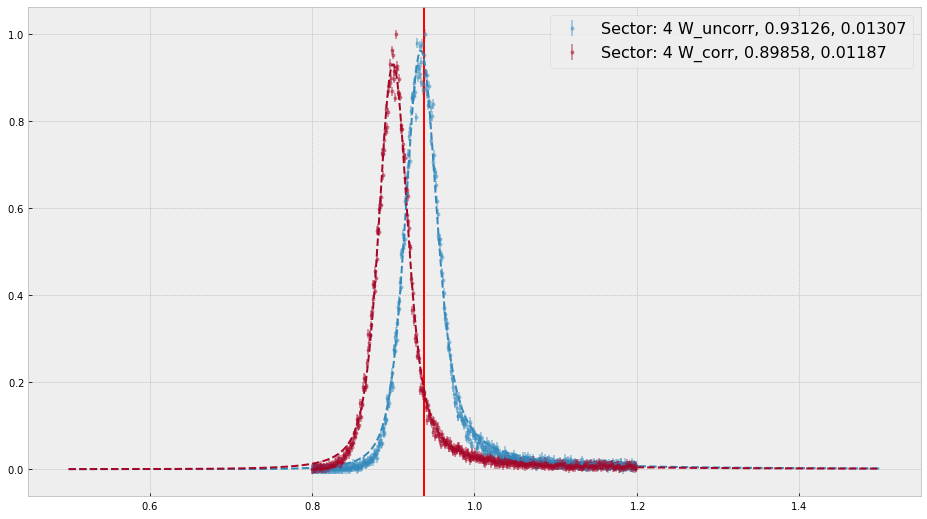

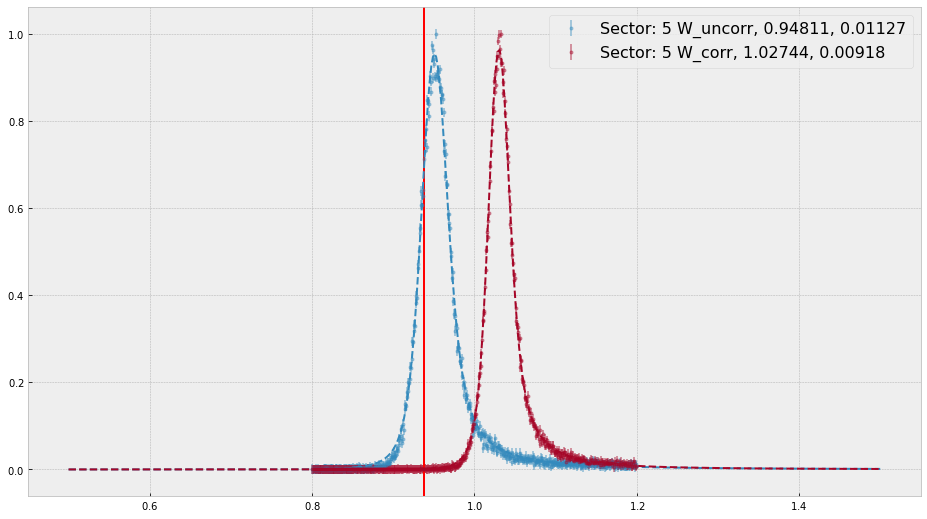

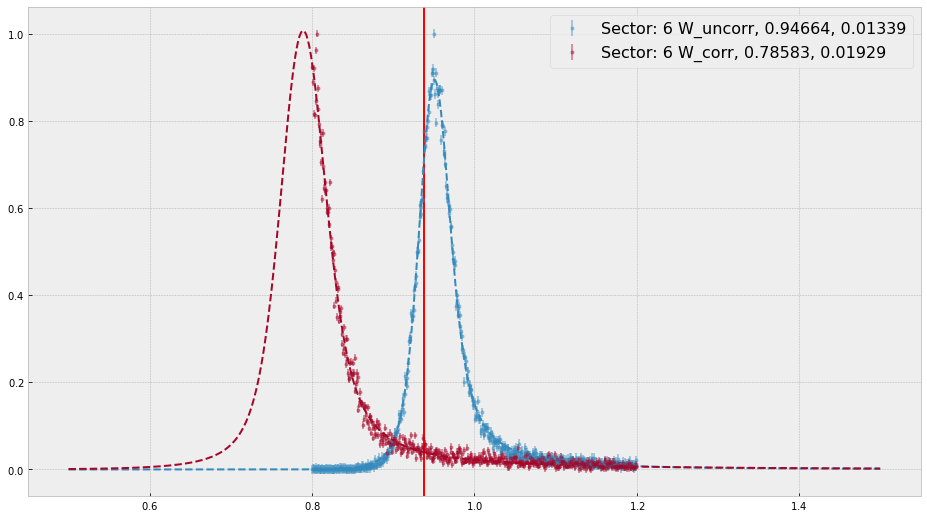

No handles with labels found to put in legend.


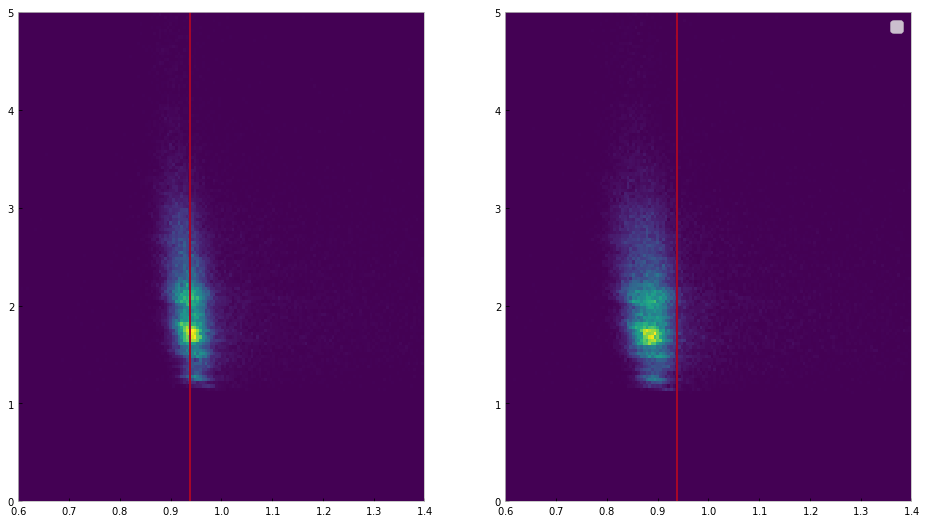

No handles with labels found to put in legend.


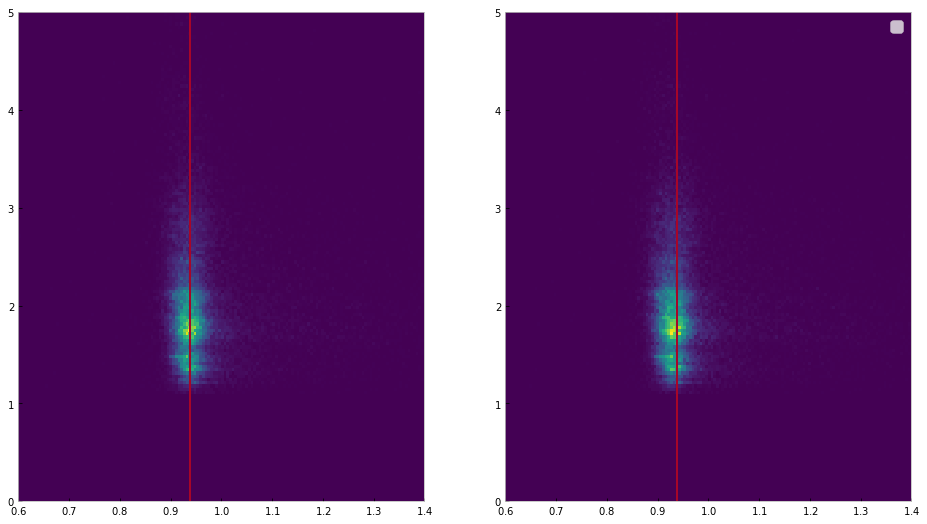

No handles with labels found to put in legend.


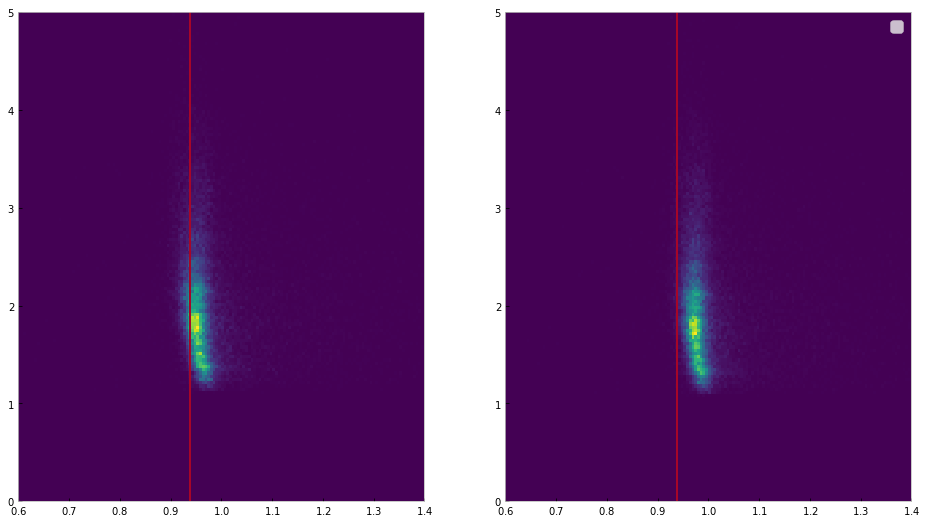

No handles with labels found to put in legend.


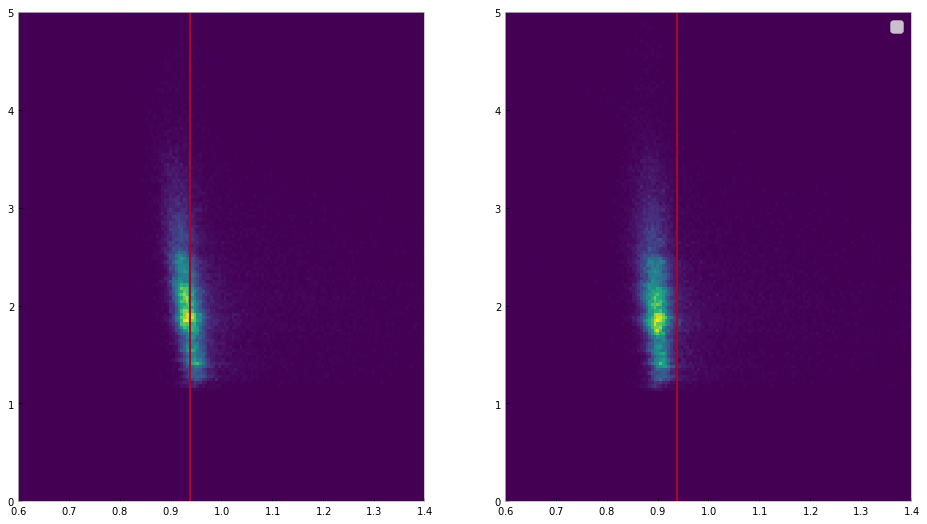

No handles with labels found to put in legend.


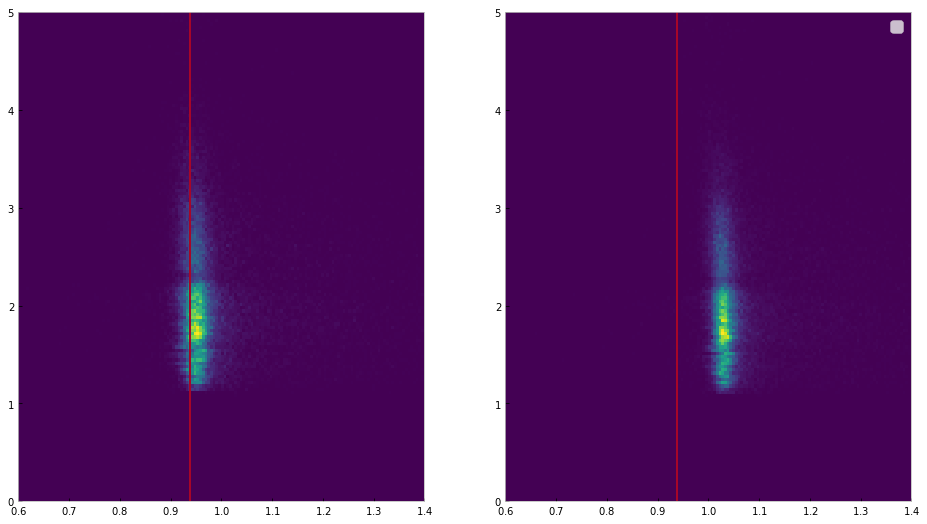

No handles with labels found to put in legend.


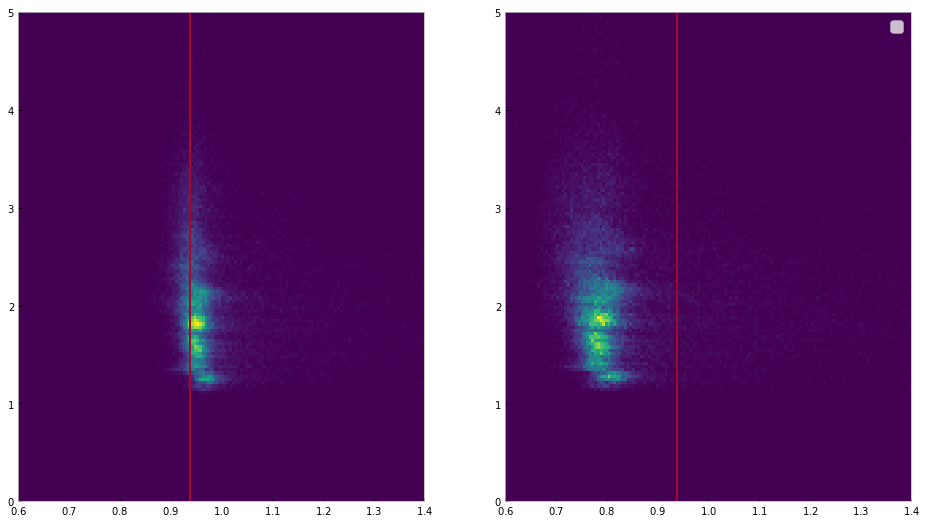

In [58]:
df['p_corr'] = df['e_p']

#for sec in [1,5,6]:
for sec in [1,2,4,5,6]:
    mask = (df.sector == sec)
    valid = df[mask].copy()
    if(sec == 4):
        sec = 1
    correction = FitFunc2(valid.e_phi, valid.e_theta,
            final_fit_parameters_P[f'sec_{sec}_A_alpha'], final_fit_parameters_P[f'sec_{sec}_A_beta'], final_fit_parameters_P[f'sec_{sec}_A_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_B_alpha'], final_fit_parameters_P[f'sec_{sec}_B_beta'], final_fit_parameters_P[f'sec_{sec}_B_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_C_alpha'], final_fit_parameters_P[f'sec_{sec}_C_beta'], final_fit_parameters_P[f'sec_{sec}_C_gamma'],
            final_fit_parameters_P[f'sec_{sec}_D_alpha'], final_fit_parameters_P[f'sec_{sec}_D_beta'], final_fit_parameters_P[f'sec_{sec}_D_gamma'],)

    df.loc[mask, 'p_corr'] = valid.e_p * correction


df['W_corr'] = calc_W(df.p_corr, df.e_theta, df.e_phi)
df['Q2_corr'] = calc_q2(df.p_corr, df.e_theta, df.e_phi)



for sec in range(1,7):
    fig = plt.figure(figsize=(16,9))
    plt.axvline(MP, c='r')
    xs=np.linspace(0.5, 1.5, 500)
    data = df[df.sector == sec]

    for W in ['W_uncorr','W_corr']:
        y, x= np.histogram(data[W], bins=500, range=(0.8,1.2))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        mod = SkewedVoigtModel()
        pars = mod.guess(y, x=x)
        out = mod.fit(y, pars, x=x, nan_policy='omit')        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.', alpha=0.4, label=f'Sector: {sec} {W}, {out.params["center"].value:0.5f}, {out.params["sigma"].value:0.5f}')
        plt.plot(xs, out.eval(x=xs), '--', c=ebar[0].get_color(), lw=2)
        
    plt.legend()
    plt.show()
    
for sec in range(1,7):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9))
    
    
    data = df[df.sector == sec]
    for i, W in enumerate(['uncorr','corr']):
        ax[i].axvline(MP, c=COLOR_RED)
        ax[i].hist2d(data[f'W_{W}'],data[f'Q2_{W}'], bins=150, range=[[0.6,1.4],[0,5]])
        
    plt.legend()
    plt.show()


In [ ]:
all_data['p_corr'] = all_data['e_p']

#for sec in [1,5,6]:
for sec in range(1,7):
    mask = (all_data.sector == sec)
    valid = all_data[mask]
    if(sec == 4):
        sec = 1

    correction = FitFunc(valid.e_phi, valid.e_theta,
            final_fit_parameters_P[f'sec_{sec}_A_alpha'], final_fit_parameters_P[f'sec_{sec}_A_beta'], final_fit_parameters_P[f'sec_{sec}_A_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_B_alpha'], final_fit_parameters_P[f'sec_{sec}_B_beta'], final_fit_parameters_P[f'sec_{sec}_B_gamma'], 
            final_fit_parameters_P[f'sec_{sec}_C_alpha'], final_fit_parameters_P[f'sec_{sec}_C_beta'], final_fit_parameters_P[f'sec_{sec}_C_gamma'],
            final_fit_parameters_P[f'sec_{sec}_D_alpha'], final_fit_parameters_P[f'sec_{sec}_D_beta'], final_fit_parameters_P[f'sec_{sec}_D_gamma'],
            final_fit_parameters_P[f'sec_{sec}_E_alpha'], final_fit_parameters_P[f'sec_{sec}_E_beta'], final_fit_parameters_P[f'sec_{sec}_E_gamma'],)
    all_data.loc[mask, 'p_corr'] = valid.e_p * correction

all_data['W_corr'] = calc_W(all_data.p_corr, all_data.e_theta, all_data.e_phi)
all_data['Q2_corr'] = calc_q2(all_data.p_corr, all_data.e_theta, all_data.e_phi)


for sec in range(1, 7):
    fig = plt.figure(figsize=(16,9))
    xs=np.linspace(0.5, 4.5, 500)
    for W in ['W_uncorr','W_corr']:
        y, x= np.histogram(all_data[all_data.sector == sec][W], bins=500, range=(0.5,3.0))
        y = y/np.max(y)
        x = (x[:-1]+x[1:])/2.0
        
        ebar = plt.errorbar(x,y, yerr=stats.sem(y),fmt='.',alpha=0.4, 
                            label=f'Sector: {sec} {W}')


    plt.legend()
    plt.show()

In [ ]:
for sec in range(1,7):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,9))

    data = all_data[all_data.sector == sec]
    for i, W in enumerate(['uncorr','corr']):
        ax[i].axvline(MP, c=COLOR_RED)
        ax[i].hist2d(data[f'W_{W}'],data[f'Q2_{W}'], bins=150, range=[[0.6,3.0],[0,5]])
        
    plt.legend()
    plt.show()


In [ ]:
for sec in range(1,7):
    print('{{',final_fit_parameters_P[f'sec_{sec}_A_alpha'],',', final_fit_parameters_P[f'sec_{sec}_A_beta'],',', final_fit_parameters_P[f'sec_{sec}_A_gamma'],'},\n',
            '{',final_fit_parameters_P[f'sec_{sec}_B_alpha'],',', final_fit_parameters_P[f'sec_{sec}_B_beta'],',', final_fit_parameters_P[f'sec_{sec}_B_gamma'],'},\n', 
            '{',final_fit_parameters_P[f'sec_{sec}_C_alpha'],',', final_fit_parameters_P[f'sec_{sec}_C_beta'],',', final_fit_parameters_P[f'sec_{sec}_C_gamma'],'},\n',
            '{',final_fit_parameters_P[f'sec_{sec}_D_alpha'],',', final_fit_parameters_P[f'sec_{sec}_D_beta'],',', final_fit_parameters_P[f'sec_{sec}_D_gamma'],'},\n',
            '{',final_fit_parameters_P[f'sec_{sec}_E_alpha'],',', final_fit_parameters_P[f'sec_{sec}_E_beta'],',', final_fit_parameters_P[f'sec_{sec}_E_gamma'],'}},\n')